In [3]:
import skimage
import tensorflow as tf
import pandas as pd
import tarfile
import tqdm
import cv2
import os
from keras.models import load_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from get_embeddings import get_embeddings
#from get_most_important_features import get_most_important_features


In [4]:
#Load celebs images and embeddings
celeb = pd.read_pickle("celeb40_full_identities_pickle")
images = celeb["images"]
images = np.stack(images)
embeddings = celeb["embeddings"]
embeddings = np.stack(embeddings)

FileNotFoundError: [Errno 2] No such file or directory: 'celeb40_full_identities_pickle'

## Explainability method

In [15]:
def normalize(v):#all values between 0 and 1
    return (v - np.min(v)) / (np.max(v) - np.min(v))

    
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    plt.axis("off")
    
decoder = load_model("decoder_celeb.h5")

def get_most_important_features(image1, image2, embedding1, embedding2, same_category= True, plot = False): #images, embeddings after index2
    #image1 and embedding1 are those of the instance used as reference.
    #image2 and embedding2 correspond to the test instance.
    #if same_category = True, the most important feature are the closest ones. The converse is true when same_category = False
    #The function returns a matrix with the relevance of every pixel.
    
    
    #Select embedding most important features     
    dist = abs(embedding1 - embedding2)
    norm_dist = normalize(dist)
    
                
    #print(len(idx_h))            

    #perturbation = normalize(1/dist) *50 #/ ((embedding2)) #+ embedding1)#closer features suffer greater perturbations.  
    if same_category:
        perturbation =  0.3 *abs(norm_dist - 1)        
    
    else:
        perturbation = (norm_dist) * 0.3
        

    #Perturb the embedding vector in its most important features, and detect the changes in the reconstructed image.

    x = decoder.predict((embedding2)[None])[0] #original reconstruction

    
    x_til = decoder.predict((perturbation + embedding2)[None])[0]
    changes = abs((x_til - x))
    changes = normalize(changes)

    
    #PLOT
    if plot:
        b = 0.65
        selection = (changes > b)*1
        for i in range(selection.shape[0]):
            for j in range(selection.shape[1]):
                if 1 in selection[i,j]:
                    selection[i,j] = [1,1,0]
                #print(selection.shape)


                
        plt.subplot(1,6,1) 
        plt.title("reference")
        show_image(image1) 
        

        plt.subplot(1,6,2) 
        plt.title("original")
        show_image(image2)
        
        plt.subplot(1,6,3) 
        plt.title("reconstruido")
        show_image(x)

        
        plt.subplot(1,6,4) 
        plt.title("")
        show_image(image2 + selection*100)
        
        
        plt.subplot(1,6,5) 
        plt.title("")
        show_image(x + selection*100)
        
        
        heat_map = np.zeros((40,40))
        for i in range(selection.shape[0]):
            for j in range(selection.shape[1]):
                    heat_map[i,j] = sum(changes[i,j])
                    
        plt.subplot(1,6,6) 
        plt.title("")
        show_image(heat_map*0.25)
        #show_image(x + selection*100)
        
        plt.axis("off")

        plt.show()

    
    return changes


In [16]:
n = 10
person_idx = celeb.index[celeb["person"]== n].tolist()
person_idx

[37, 38, 39]

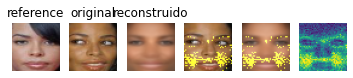

In [19]:
index1 = 37
index2 = 38
a = get_most_important_features(images[index2], images[index1], embeddings[index2], embeddings[index1], same_category= True, plot = True) #images, embeddings after index2
#show_image(a)
#plt.savefig("original 1", format = pdf)

## Quality assesment method


In [27]:
def quality_assesment(image1, image2, embedding1, embedding2, k = 10, size = 5, plot = False,  same_category= True): #matrix is an image of the perturbation magnitudes.
    #k is the number of superpixels to be perturbed. 
    # size is the length of the sides of the square superpixel
    
    
    image1 = np.copy(image1)
    image2 = np.copy(image2)
    
    
    img_dimension = image1.shape[0]
    changes_matrix = get_most_important_features(image1, image2, embedding1, embedding2, same_category)
    
    
    distance =  np.dot(embedding1,embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))
    
    

    #Get the value associated to every superpixel

    mini_sum = []

    row_size = changes_matrix.shape[0]//size
    column_size = changes_matrix.shape[1]//size

    assert row_size == changes_matrix.shape[0]/size
    assert column_size ==  changes_matrix.shape[1]/size

    for i in range(row_size):
        for j in range(column_size):        
            mini_sum.append(sum(sum(sum(changes_matrix[i*size : i*size+size, j*size : j*size+size,:]))))
            
    sorted_values = (sorted(mini_sum, reverse=True)[:k])
    
    superpixel_values_absolute = np.array(sorted_values)/(size*size*3)
    superpixel_values = normalize(sorted_values)
  
    #Perturb the most important superpixel, and save its similarity with the reference image in perturbed_distance_list. 
    #Iterate k times
    
    perturbed_distance_list = [distance]

    perturbed_images_list = []
    perturbed_reference = []
    for i in range(k):
        idx_max = np.argmax(mini_sum)
        row= idx_max//(img_dimension//size)
        column = idx_max%(img_dimension//size)
        row, column #position of the most important superpixel

        mini_sum[idx_max] = 0 

        perturbation = np.random.randn(size,size,3)* 0.1
    
        image2 = np.copy(image2)
        image2[row*size: row*size+size , column*size: column*size+size, :] = perturbation
        perturbed_images_list.append(image2)

        
        if same_category == False:
            image1 = np.copy(image1)
            image1[row*size: row*size+size , column*size: column*size+size, :] = perturbation 
            perturbed_reference.append(image1)
        
        
        if plot:
            if same_category:
                plt.subplot(1,k,1+i) 
                plt.title("")
                show_image(image2)
            
            else:
                plt.subplot(2,k,1+i) 
                plt.title("")
                show_image(image1)
                
                plt.subplot(2,k,1+i+ k) 
                plt.title("")
                show_image(image2)

        
    perturbed_embs = get_embeddings(image_list = perturbed_images_list)[1] #get embedding of the perturbed image.
    
    if same_category == False:
        perturbed_reference_embs = get_embeddings(image_list = perturbed_reference)[1] 
    
    
    if same_category:
        for emb in perturbed_embs:
            perturbed_distance =  np.dot(embedding1, emb)/(np.linalg.norm(embedding1)*np.linalg.norm(emb))
            perturbed_distance_list.append(perturbed_distance)
            
    else:
        for i in range(len(perturbed_embs)):
            perturbed_distance =  np.dot(perturbed_reference_embs[i], perturbed_embs[i])/(np.linalg.norm(perturbed_reference_embs[i])*np.linalg.norm(perturbed_embs[i]))
            perturbed_distance_list.append(perturbed_distance)

    
    #Do absolute and normalized
    #For normalized:
    perturbed_distance_list = np.array(perturbed_distance_list)
    normalized_distance =  perturbed_distance_list/distance
    
    if same_category == False:
        normalized_distance = (perturbed_distance_list+1)/(distance + 1) #perturbed_distance_list+1/(distance + 1)

    
    
    plt.show()

    return perturbed_distance_list, normalized_distance, superpixel_values_absolute, superpixel_values
    #Maybe it will be faster to get all the embeddings of the perturbed images first? for avoiding innecessary iterations
    #Another option is to create a dict that saves the values and recover them if they are needed again. 
    #but the problem is that it's highly improbable that the same perturbations will take place when comparing the reference to a different image. 
    #THIS PROCESS IS GONNA BE COMPUTATIONALLY EXPENSIVE.


In [20]:

n = 281
person_idx = celeb.index[celeb["person"]== n].tolist()
index1 = person_idx[0]
index2 = person_idx[1]


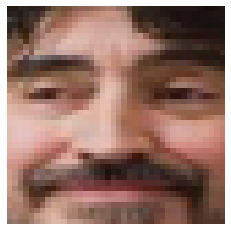

In [21]:
show_image(images[index1])


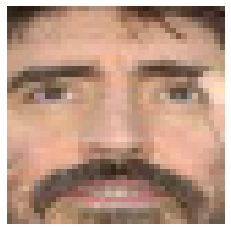

In [22]:
show_image(images[index2])


Instructions for updating:
Use tf.gfile.GFile.


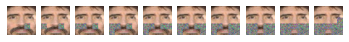

absolute difference
[0.74396396 0.68965987 0.6539817  0.65360411 0.65611078 0.63302846
 0.64228264 0.63416539 0.63715246 0.60555544 0.62044459]
relative difference
[1.         0.9270071  0.87905024 0.87854271 0.88191205 0.85088593
 0.86332495 0.85241414 0.85642921 0.81395803 0.83397131]
superpixel relevance absolute
[0.52336011 0.49628967 0.48279644 0.47597315 0.45388134 0.44591181
 0.42871026 0.42548819 0.37895839 0.35007483]
superpixel relevance relative
[1.         0.84378106 0.76591392 0.72653787 0.5990498  0.553059
 0.45379176 0.43519775 0.16668216 0.        ]


In [25]:

a, b, c, d = quality_assesment(images[index1], images[index2], embeddings[index1], embeddings[index2], k = 10, size = 8, plot = True)
#plt.savefig("Imagenes_esquemas\perturbaciones1", format = "pdf")

print("absolute difference")
print(a)
print("relative difference")
print(b)
print("superpixel relevance absolute")
print(c)
print("superpixel relevance relative")
print(d)

In [29]:
persons = []
size = 5
for i in range(60):
    persons.append((1 + i))#Assess the method for the first 60 identities. 
    

c = 0
absolute_sum = 0
normalized_sum = 0
pix_values_sum = 0
pix_values_abs_sum = 0

for n in tqdm.tqdm_notebook(persons):
    person_idx = celeb.index[celeb["person"]== n].tolist()
    for i in person_idx[0:2]:
        for j in person_idx[0:2]:
            if i < j:
                distance =  np.dot(embeddings[i], embeddings[j])/(np.linalg.norm(embeddings[i])*np.linalg.norm(embeddings[j]))
                if distance > 0.30:
                    c += 1
                    absolute, normalized, pix_values_abs, pix_values = quality_assesment(images[i], images[j], embeddings[i], embeddings[j], same_category = True,size = size, k = 20)
                    absolute_sum += absolute
                    normalized_sum += normalized
                    pix_values_sum += pix_values
                    pix_values_abs_sum += pix_values_abs

average_absolute = absolute_sum/c
average_normalized = normalized_sum/c 
average_pix_values_abs = pix_values_abs_sum/c
average_pix_values = pix_values_sum / c
print(average_absolute)
print(average_normalized)
print("superpixels values")
print()
print(average_pix_values)
print(c)

C:\Users\pablo\AppData\Local\Temp\ipykernel_15492\2580116740.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm.tqdm_notebook(persons):


  0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\pablo\TFM\get_embeddings.py:185: RuntimeWarning: invalid value encountered in multiply
  emb = np.ndarray((n_images, 512))*0


[0.6419214  0.62819851 0.6100442  0.59747186 0.59571799 0.58546163
 0.57093209 0.55679016 0.54646706 0.52787309 0.5195188  0.50953214
 0.49353742 0.49297039 0.47950588 0.46675744 0.45336694 0.44506234
 0.44142317 0.435204   0.42884818]
[1.         0.97355137 0.93756424 0.91422815 0.91351427 0.89921701
 0.87380554 0.85197372 0.83684142 0.80386389 0.7919222  0.77698936
 0.74907324 0.7464472  0.72777771 0.70819509 0.68579827 0.67300355
 0.66883496 0.66126716 0.65365469]
superpixels values

[1.         0.87587163 0.74307866 0.68079401 0.63956856 0.58295803
 0.52070724 0.47752776 0.43771532 0.38861012 0.3601131  0.3066029
 0.27101999 0.22796946 0.19129889 0.1354689  0.08770397 0.05413659
 0.02491281 0.        ]
40


Text(0, 0.5, 'normalized similarity score')

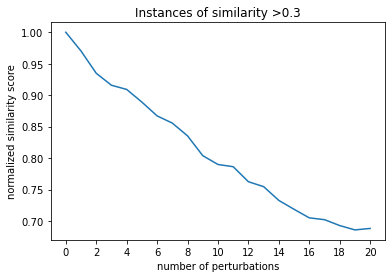

In [53]:


plt.plot(average_normalized)
plt.xticks(np.arange(0,22,2))
plt.title("Instances of similarity >0.3")
plt.xlabel("number of perturbations") #super pixels removed
plt.ylabel("normalized similarity score")

#plt.savefig("Gráficos\ normalized_0.3.png", format = "png")